In [1]:
import os, re, magic, shutil
from glob import glob
import time, datetime
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
import warnings
import joblib
import datetime as dt

import cv2
from PIL import Image
import matplotlib.pyplot as plt
import torch, gc
from torch import nn
from torch.utils.data import Dataset,DataLoader
import torch.nn.functional as F
import torchvision
import torchvision.models as models

#from skimage import io
import sklearn
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, log_loss, f1_score, confusion_matrix, classification_report
from sklearn import metrics, preprocessing
from scipy.ndimage import zoom

import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
import albumentations as A
import albumentations.pytorch
import wandb


#### Hyper Param Setting

In [2]:
CFG = {
    'fold_num': 5,
    'seed': 42,
    'model': 'resnet152',
    'img_size': 260,
    'epochs': 200,
    'train_bs':64,
    'valid_bs':64,
    'lr': 1e-4, ## learning rate
    'num_workers': 8,
    'verbose_step': 1,
    'patience' : 5,
    'device': 'cuda:0',
    'freezing': False,
    'trainable_layer': 12,
    'model_path': './models'
}

#### wandb init

In [3]:
time_now = dt.datetime.now()
run_id = time_now.strftime("%Y%m%d%H%M%S")
project_name = 'KD_resnet152_19class_' + run_id
user = 'hojunking'
run_name = project_name

In [4]:
path = '../Data/carbon_data/'
dis_names = []
for folder, subfolders, filenames in os.walk(path):
    for img in filenames:
        dis_names.append(folder+'/'+img)
print(len(dis_names))

44324


In [5]:
main_path = '../Data/carbon_data/'
# label_list = ["10Kwalk","battery",'box','else','bottle','handkerchief',
#               'milk', 'paper', 'pet','plug','receipt', 'shopping bag', 'stairs',
#              'transportation', 'trash picking', 'plate']

label_list = ["10Kwalk","battery",'box','else','toothcup', 'tumbler','handkerchief',
              'milk', 'paper', 'pet','plug','receipt', 'shopping bag', 'stairs',
             'transportation', 'trash picking', 'green dish','leftover','wrap']

total_train_img_paths = []
total_train_img_labels = []
total_test_img_paths = []
total_test_img_labels = []

for label in label_list: ## 각 레이블 돌기
    print(f'label: {label}')
    img_paths = [] 
    img_labels = []

    # default ratio
    train_ratio = 1500
    test_ratio = 500

    dir_path = main_path + label ## 레이블 폴더 경로
    count = 0
    for folder, subfolders, filenames in os.walk(dir_path): ## 폴더 내 모든 파일 탐색
    
        for img in filenames: ## 각 파일 경로, 레이블 저장
            count +=1
            if count > train_ratio + test_ratio + 10000:
                break
            
            img_paths.append(folder+'/'+img)
            img_labels.append(label)
        
    random.shuffle(img_paths)
    print(f'img_paths len : {len(img_paths)}\n')

    if label == 'else': ## 10walking 데이터 비율 설정하기 (데이터수: 2494)
        train_ratio = 3000
        test_ratio = 745
    elif label == 'green dish': 
        train_ratio = 1300
        test_ratio = 382
    elif label == 'leftover': 
        train_ratio = 1600
        test_ratio = 378
    elif label == 'wrap': 
        train_ratio = 1200
        test_ratio = 489
    elif label == 'handkerchief':
        train_ratio = 2000
        test_ratio = 433     
    elif label == 'milk':
        train_ratio = 2000
        test_ratio = 374
    elif label == 'paper':
        train_ratio = 1300
        test_ratio = 365
    elif label == 'pet':
        train_ratio = 2000
        test_ratio = 402
    elif label == 'plug':
        train_ratio = 2200
        test_ratio = 725
    elif label == 'receipt':
        train_ratio = 600
        test_ratio = 243 
    elif label == 'shopping bag':
        train_ratio = 1300
        test_ratio = 413
    elif label == 'stairs':
        train_ratio = 3000
        test_ratio = 1057
    elif label == 'toothcup':
        train_ratio = 2200
        test_ratio = 607
    elif label == 'tumbler':
        train_ratio = 2545
        test_ratio = 800
    elif label == 'transportation':
        train_ratio = 1800
        test_ratio = 435
    elif label == 'trash picking':
        train_ratio = 1300
        test_ratio = 327
    elif label == '10Kwalk':
        train_ratio = 1556
        test_ratio = 400
    elif label == 'battery':
        train_ratio = 2305
        test_ratio = 500
    elif label == 'box':
        train_ratio = 1600
        test_ratio = 388
        
    total_train_img_paths.extend(img_paths[:train_ratio])
    total_train_img_labels.extend(img_labels[:train_ratio])

    total_test_img_paths.extend(img_paths[-test_ratio:])
    total_test_img_labels.extend(img_labels[-test_ratio:])

print('Train_Images: ',len(total_train_img_paths))
print("Train_Images_labels:", len(total_train_img_labels))
print('Test_Images: ',len(total_test_img_paths))
print("Test_Images_labels:", len(total_test_img_labels))
print("All data",len(total_train_img_paths) + len(total_test_img_paths))

label: 10Kwalk
img_paths len : 1956

label: battery
img_paths len : 2805

label: box
img_paths len : 1988

label: else
img_paths len : 3785

label: toothcup
img_paths len : 2807

label: tumbler
img_paths len : 3345

label: handkerchief
img_paths len : 2433

label: milk
img_paths len : 2375

label: paper
img_paths len : 1665

label: pet
img_paths len : 2404

label: plug
img_paths len : 2931

label: receipt
img_paths len : 843

label: shopping bag
img_paths len : 1713

label: stairs
img_paths len : 4061

label: transportation
img_paths len : 2236

label: trash picking
img_paths len : 1628

label: green dish
img_paths len : 1682

label: leftover
img_paths len : 1978

label: wrap
img_paths len : 1689

Train_Images:  34806
Train_Images_labels: 34806
Test_Images:  9463
Test_Images_labels: 9463
All data 44269


In [24]:
## Pandas 데이터프레임 만들기
trn_df = pd.DataFrame(total_train_img_paths, columns=['image_id'])
trn_df['dir'] = trn_df['image_id'].apply(lambda x: os.path.dirname(x))
trn_df['image_id'] = trn_df['image_id'].apply(lambda x: os.path.basename(x))
trn_df['label'] = total_train_img_labels
train = trn_df
train

,image_id,dir,label
0,10Kwalk_584.jpg,../Data/carbon_data/10Kwalk,10Kwalk
1,10Kwalk_22.jpg,../Data/carbon_data/10Kwalk,10Kwalk
2,10Kwalk_1455.jpg,../Data/carbon_data/10Kwalk,10Kwalk
3,10Kwalk_1397.jpg,../Data/carbon_data/10Kwalk,10Kwalk
4,10Kwalk_95.jpg,../Data/carbon_data/10Kwalk,10Kwalk
...,...,...,...
34801,wrap_844.jpg,../Data/carbon_data/wrap,wrap
34802,wrap_1521.jpg,../Data/carbon_data/wrap,wrap
34803,wrap_1154.jpg,../Data/carbon_data/wrap,wrap
34804,wrap_1467.jpg,../Data/carbon_data/wrap,wrap


In [25]:
# Label Encoding
le = preprocessing.LabelEncoder()
train['label'] = le.fit_transform(train['label'].values)

In [8]:
train

,image_id,dir,label
0,10Kwalk_584.jpg,../Data/carbon_data/10Kwalk,0
1,10Kwalk_22.jpg,../Data/carbon_data/10Kwalk,0
2,10Kwalk_1455.jpg,../Data/carbon_data/10Kwalk,0
3,10Kwalk_1397.jpg,../Data/carbon_data/10Kwalk,0
4,10Kwalk_95.jpg,../Data/carbon_data/10Kwalk,0
...,...,...,...
34801,wrap_844.jpg,../Data/carbon_data/wrap,18
34802,wrap_1521.jpg,../Data/carbon_data/wrap,18
34803,wrap_1154.jpg,../Data/carbon_data/wrap,18
34804,wrap_1467.jpg,../Data/carbon_data/wrap,18


In [9]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [10]:
def get_img(path, sub_path=None):
    try:
        im_bgr = cv2.imread(path)
        im_rgb = im_bgr[:, :, ::-1]
        past_path = path
    except: ## 이미지 에러 발생 시 백지로 대체
        im_bgr = cv2.imread('../Data/carbon_reduction/temp_img.jpg')
        im_rgb = im_bgr[:, :, ::-1]
    return im_rgb

In [11]:
transform_train = A.Compose(
    [
        A.RandomResizedCrop(p=1, height=CFG['img_size'] ,width=CFG['img_size'], scale=(0.65, 0.75),ratio=(0.90, 1.10)),
        A.SafeRotate(p=0.5, limit=(-20, 20), interpolation=2, border_mode=0, value=(0, 0, 0), mask_value=None),
        A.HorizontalFlip(p=0.5),
        A.ColorJitter(always_apply=True, p=0.5, contrast=0.2, saturation=0.3, hue=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
        A.pytorch.transforms.ToTensorV2()
        ])

transform_train_cap = A.Compose(
    [
        A.RandomResizedCrop(p=1, height=CFG['img_size'] ,width=CFG['img_size'], scale=(0.65, 0.85),ratio=(0.90, 1.10)),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
        A.pytorch.transforms.ToTensorV2()
        ])

transform_test = A.Compose(
    [
        A.Resize(height = CFG['img_size'], width = CFG['img_size']),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
        A.pytorch.transforms.ToTensorV2()
        ])

In [12]:
class ColonDataset(Dataset):
    def __init__(self, df, data_root, transform=None, transform2=None, output_label=True):
        super().__init__()
        self.df = df.reset_index(drop=True).copy()
        self.transform = transform
        self.transform2 = transform2
        self.data_root = data_root
        self.output_label = output_label
        
        if output_label == True:
            self.labels = self.df['label'].values
        
        # EXEPTION TRANSFORM FOR CAPTURE IMAGES
        self.cap_image = le.fit_transform(['10Kwalk', 'battery','receipt'])
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index: int):
        # GET labels
        if self.output_label:
            target = self.labels[index]
        # GET IMAGES
        path = "{}/{}".format(self.data_root[index], self.df.iloc[index]['image_id'])
        img  = get_img(path)
        
        # TRANSFORM1, TRANSFORM2 PROCESS
        if self.transform2 :
            if target in self.cap_image and self.transform2:
                transformed = self.transform2(image=img)
            else:
                transformed = self.transform(image=img)
        elif self.transform:
            transformed = self.transform(image=img)
        img = transformed['image']
                
        if self.output_label == True:
            return img, target
        else:
            return img

In [13]:
# LOAD PRE-TRAINED MODEL
class Teacher(nn.Module):
    def __init__(self, model_arch, num_classes= 2,pretrained=True):
        super(Teacher, self).__init__()
        self.backbone = models.resnet152(pretrained=pretrained) ## 모델 선언 여기 models.##(pretrained =pretrained)
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, num_classes)
        
    def forward(self, x):
        x = self.backbone(x)
        return x

In [14]:
# class ForcepImgClassifier(nn.Module):
#     def __init__(self, model_arch, n_class=2, pretrained=False):
#         super().__init__()
#         self.model = timm.create_model(model_arch, pretrained=pretrained, num_classes=n_class)
#         # n_features = self.model.classifier.in_features
#         # self.model.classifier = nn.Linear(n_features, n_class)
#     def freezing(self, freeze=False, trainable_layer = 2):
        
#         if freeze:
#             num_layers = len(list(model.parameters()))
#             for i, param in enumerate(model.parameters()):
#                 if i < num_layers - trainable_layer*2:
#                     param.requires_grad = False    
            
#     def forward(self, x):
#         x = self.model(x)
#         return x

In [15]:
def prepare_dataloader(df, trn_idx, val_idx, data_root=train.dir.values):
    
    train_ = df.loc[trn_idx,:].reset_index(drop=True)
    valid_ = df.loc[val_idx,:].reset_index(drop=True)
    train_data_root = data_root[trn_idx]
    valid_data_root = data_root[val_idx]
    
        
    train_ds = ColonDataset(train_,
                            train_data_root,
                            transform=transform_train,
                            transform2=transform_train_cap,
                            output_label=True)
    valid_ds = ColonDataset(valid_,
                            valid_data_root,
                            transform=transform_test,
                            output_label=True)
    # WEIGHTEDRANDOMSAMPLER
    class_counts = train_.label.value_counts(sort=False).to_dict()
    num_samples = sum(class_counts.values())
    print(f'cls_cnts: {len(class_counts)}\nnum_samples:{num_samples}')
    
    # weight 제작, 전체 학습 데이터 수를 해당 클래스의 데이터 수로 나누어 줌
    class_weights = {l:round(num_samples/class_counts[l], 2) for l in class_counts.keys()}
    t_labels = train_.label.to_list()
    
    # class 별 weight를 전체 trainset에 대응시켜 sampler에 넣어줌
    weights = [class_weights[t_labels[i]] for i in range(int(num_samples))]


    # weight 제작, 전체 학습 데이터 수를 해당 클래스의 데이터 수로 나누어 줌
    class_weights = {l:round(num_samples/class_counts[l], 2) for l in class_counts.keys()}

    # class 별 weight를 전체 trainset에 대응시켜 sampler에 넣어줌
    weights = [class_weights[t_labels[i]] for i in range(int(num_samples))] 
    sampler = torch.utils.data.WeightedRandomSampler(torch.DoubleTensor(weights), int(num_samples))
    
    train_loader = torch.utils.data.DataLoader(
        train_ds,
        batch_size=CFG['train_bs'],
        pin_memory=True,
        drop_last=False,
        shuffle=False,
        sampler=sampler, 
        num_workers=CFG['num_workers']
    )
    val_loader = torch.utils.data.DataLoader(
        valid_ds, 
        batch_size=CFG['valid_bs'],
        num_workers=CFG['num_workers'],
        shuffle=False,
        pin_memory=True,
    )
    return train_loader, val_loader

In [16]:
def train_one_epoch(epoch, model, loss_fn, optimizer, train_loader, device, scheduler=None):
    ## Sets the model to training mode
    model.train()
    
    t = time.time()
    running_loss = None
    loss_sum = 0
    image_preds_all = []
    image_targets_all = []
    acc_list = []
    
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for step, (imgs, image_labels) in pbar:
        imgs = imgs.to(device).float()
        image_labels = image_labels.to(device).long()
        optimizer.zero_grad()
        
        with torch.cuda.amp.autocast():
            image_preds = model(imgs)   #output = model(input)

            loss = loss_fn(image_preds, image_labels)
            loss_sum+=loss.detach()
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        
            if running_loss is None:
                running_loss = loss.item()
            else:
                running_loss = running_loss * .99 + loss.item() * .01    
        
        
            if ((step + 1) % CFG['verbose_step'] == 0) or ((step + 1) == len(train_loader)):
                description = f'epoch {epoch} loss: {running_loss:.4f}'
                pbar.set_description(description)
        
        image_preds_all += [torch.argmax(image_preds, 1).detach().cpu().numpy()]
        image_targets_all += [image_labels.detach().cpu().numpy()]
        
    if scheduler is not None:
        scheduler.step()
    
    image_preds_all = np.concatenate(image_preds_all)
    image_targets_all = np.concatenate(image_targets_all)
    
    matrix = confusion_matrix(image_targets_all,image_preds_all)
    epoch_f1 = f1_score(image_targets_all, image_preds_all, average='macro')
    
    accuracy = (image_preds_all==image_targets_all).mean()
    trn_loss = loss_sum/len(train_loader)
    
    return image_preds_all, accuracy, trn_loss, matrix, epoch_f1

def valid_one_epoch(epoch, model, loss_fn, val_loader, device, scheduler=None, schd_loss_update=False):
    ## Sets the model to valid mode
    model.eval()

    t = time.time()
    loss_sum = 0
    sample_num = 0
    avg_loss = 0
    image_preds_all = []
    image_targets_all = []
    
    acc_list = []
    
    pbar = tqdm(enumerate(val_loader), total=len(val_loader))
    for step, (imgs, image_labels) in pbar:
        imgs = imgs.to(device).float()
        image_labels = image_labels.to(device).long()
        
        image_preds = model(imgs)   #output = model(input)
        image_preds_all += [torch.argmax(image_preds, 1).detach().cpu().numpy()]
        image_targets_all += [image_labels.detach().cpu().numpy()]
        
        loss = loss_fn(image_preds, image_labels)
        avg_loss += loss.item()
        loss_sum += loss.item()*image_labels.shape[0]
        sample_num += image_labels.shape[0]
        
        description = f'epoch {epoch} loss: {loss_sum/sample_num:.4f}'
        pbar.set_description(description)
    
    image_preds_all = np.concatenate(image_preds_all)
    image_targets_all = np.concatenate(image_targets_all)
    matrix = confusion_matrix(image_targets_all,image_preds_all)
    
    epoch_f1 = f1_score(image_targets_all, image_preds_all, average='macro')
    acc = (image_preds_all==image_targets_all).mean()
    val_loss = avg_loss/len(val_loader)
    
    return image_preds_all, acc, val_loss, matrix, epoch_f1

In [17]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, score):
        print(f' present score: {score}')
        if self.best_score is None:
            self.best_score = score
        elif score <= self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            print(f'Best F1 score from now: {self.best_score}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0
        
        return self.early_stop

In [ ]:
if __name__ == '__main__':
    seed_everything(CFG['seed'])
    
    # WANDB TRACKER INIT
    wandb.init(project=project_name, entity=user)
    wandb.config.update(CFG)
    wandb.run.name = run_name
    wandb.define_metric("Train Accuracy", step_metric="epoch")
    wandb.define_metric("Valid Accuracy", step_metric="epoch")
    wandb.define_metric("Train Loss", step_metric="epoch")
    wandb.define_metric("Valid Loss", step_metric="epoch")
    wandb.define_metric("Train Macro F1 Score", step_metric="epoch")
    wandb.define_metric("Valid Macro F1 Score", step_metric="epoch")
    wandb.define_metric("Train-Valid Accuracy", step_metric="epoch")
    
    model_dir = CFG['model_path'] + '/{}_{}'.format(CFG['model'], run_id)
    train_dir = train.dir.values
    best_fold = 0
    best_f1 =0.0
    print('Model: {}'.format(CFG['model']))
    # MAKE MODEL DIR
    if not os.path.isdir(model_dir):
        os.makedirs(model_dir)
    
    # STRATIFIED K-FOLD DEFINITION
    folds = StratifiedKFold(n_splits=CFG['fold_num'], shuffle=True, random_state=CFG['seed']).split(np.arange(train.shape[0]), train.label.values)
    
    # TEST PROCESS FOLD BREAK
    for fold, (trn_idx, val_idx) in enumerate(folds):
        print(f'Training start with fold: {fold} epoch: {CFG["epochs"]} \n')

        # EARLY STOPPING DEFINITION
        early_stopping = EarlyStopping(patience=CFG["patience"], verbose=True)

        # DATALOADER DEFINITION
        train_loader, val_loader = prepare_dataloader(train, trn_idx, val_idx, data_root=train_dir)

        # MODEL & DEVICE DEFINITION 
        device = torch.device(CFG['device'])
        #model = ForcepImgClassifier(CFG['model'], train.label.nunique(), pretrained=True)
        model =Teacher(CFG['model'], train.label.nunique(), pretrained=True)
        
        # MODEL FREEZING
        #model.freezing(freeze = CFG['freezing'], trainable_layer = CFG['trainable_layer'])
        if CFG['freezing'] ==True:
            for name, param in model.named_parameters():
                if param.requires_grad == True:
                    print(f"{name}: {param.requires_grad}")

        model.to(device)
        # MODEL DATA PARALLEL
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)

        scaler = torch.cuda.amp.GradScaler()   
        optimizer = torch.optim.Adam(model.parameters(), lr=CFG['lr'])
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.5, step_size=5)

        # CRITERION (LOSS FUNCTION)
        loss_tr = nn.CrossEntropyLoss().to(device) #MyCrossEntropyLoss().to(device)
        loss_fn = nn.CrossEntropyLoss().to(device)

        wandb.watch(model, loss_tr, log='all')
        train_acc_list = []
        train_matrix_list = []
        train_f1_list = []
        valid_acc_list = []
        valid_matrix_list = []
        valid_f1_list = []
        

        start = time.time()
        print(f'Fold: {fold}')
        for epoch in range(CFG['epochs']):
            print('Epoch {}/{}'.format(epoch, CFG['epochs'] - 1))

            # TRAINIG
            train_preds_all, train_acc, train_loss, train_matrix, train_f1 = train_one_epoch(epoch, model, loss_tr,
                                                                        optimizer, train_loader, device, scheduler=scheduler)
            wandb.log({'Train Accuracy':train_acc, 'Train Loss' : train_loss, 'Train F1': train_f1, 'epoch' : epoch})

            # VALIDATION
            with torch.no_grad():
                valid_preds_all, valid_acc, valid_loss, valid_matrix, valid_f1= valid_one_epoch(epoch, model, loss_fn,
                                                                        val_loader, device, scheduler=None)
                wandb.log({'Valid Accuracy':valid_acc, 'Valid Loss' : valid_loss, 'Valid F1': valid_f1 ,'epoch' : epoch})
            print(f'Epoch [{epoch}], Train Loss : [{train_loss :.5f}] Val Loss : [{valid_loss :.5f}] Val F1 Score : [{valid_f1:.5f}]')
            
            # SAVE ALL RESULTS
            train_acc_list.append(train_acc)
            train_matrix_list.append(train_matrix)
            train_f1_list.append(train_f1)

            valid_acc_list.append(valid_acc)
            valid_matrix_list.append(valid_matrix)
            valid_f1_list.append(valid_f1)

            # MODEL SAVE (THE BEST MODEL OF ALL OF FOLD PROCESS)
            if valid_f1 > best_f1:
                best_f1 = valid_f1
                best_epoch = epoch
                torch.save(model.state_dict(), (model_dir+'/{}').format(CFG['model']))

            # EARLY STOPPING
            stop = early_stopping(valid_f1)
            if stop:
                print("stop called")   
                break

        end = time.time() - start
        time_ = str(datetime.timedelta(seconds=end)).split(".")[0]
        print("time :", time_)

        # PRINT BEST F1 SCORE MODEL OF FOLD
        best_index = valid_f1_list.index(max(valid_f1_list))
        print(f'fold: {fold}, Best Epoch : {best_index}/ {len(valid_f1_list)}')
        print(f'Best Train Marco F1 : {train_f1_list[best_index]:.5f}')
        print(train_matrix_list[best_index])
        print(f'Best Valid Marco F1 : {valid_f1_list[best_index]:.5f}')
        print(valid_matrix_list[best_index])
        print('-----------------------------------------------------------------------')

        # K-FOLD END
        if valid_f1_list[best_index] > best_fold:
            best_fold = valid_f1_list[best_index]
            top_fold = fold
    print(f'Best Fold F1 score: {best_fold} Top fold : {top_fold}')


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hojunking. Use `wandb login --relogin` to force relogin


Model: resnet152
Training start with fold: 0 epoch: 200 

cls_cnts: 19
num_samples:27844


/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold: 0
Epoch 0/199


epoch 0 loss: 0.3405: 100%|███████████████████| 109/109 [02:36<00:00,  1.44s/it]


Epoch [0], Train Loss : [0.47243] Val Loss : [0.34043] Val F1 Score : [0.89428]
 present score: 0.8942817161082509
Epoch 1/199


epoch 1 loss: 0.2867: 100%|███████████████████| 109/109 [02:34<00:00,  1.42s/it]


Epoch [1], Train Loss : [0.25198] Val Loss : [0.28639] Val F1 Score : [0.92090]
 present score: 0.9208978321401137
Epoch 2/199


epoch 2 loss: 0.3345: 100%|███████████████████| 109/109 [02:35<00:00,  1.43s/it]

Epoch [2], Train Loss : [0.20356] Val Loss : [0.33424] Val F1 Score : [0.90413]
 present score: 0.904127434828599
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.9208978321401137
Epoch 3/199



epoch 3 loss: 0.2918: 100%|███████████████████| 109/109 [02:43<00:00,  1.50s/it]


Epoch [3], Train Loss : [0.17697] Val Loss : [0.29200] Val F1 Score : [0.92397]
 present score: 0.9239745404623736
Epoch 4/199


epoch 4 loss: 0.3012: 100%|███████████████████| 109/109 [02:36<00:00,  1.44s/it]

Epoch [4], Train Loss : [0.14995] Val Loss : [0.30106] Val F1 Score : [0.91864]
 present score: 0.918644674638371
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.9239745404623736
Epoch 5/199



epoch 5 loss: 0.2129: 100%|███████████████████| 109/109 [02:38<00:00,  1.45s/it]


Epoch [5], Train Loss : [0.08989] Val Loss : [0.21274] Val F1 Score : [0.94262]
 present score: 0.9426197830578065
Epoch 6/199


epoch 6 loss: 0.2110: 100%|███████████████████| 109/109 [02:35<00:00,  1.43s/it]


Epoch [6], Train Loss : [0.07000] Val Loss : [0.21107] Val F1 Score : [0.94448]
 present score: 0.9444759643792634
Epoch 7/199


epoch 7 loss: 0.2366: 100%|███████████████████| 109/109 [02:37<00:00,  1.45s/it]

Epoch [7], Train Loss : [0.06004] Val Loss : [0.23636] Val F1 Score : [0.94159]
 present score: 0.9415866169850043
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.9444759643792634
Epoch 8/199



epoch 8 loss: 0.2415: 100%|███████████████████| 109/109 [02:38<00:00,  1.45s/it]

Epoch [8], Train Loss : [0.05784] Val Loss : [0.24147] Val F1 Score : [0.93841]
 present score: 0.9384144372814013
EarlyStopping counter: 2 out of 5
Best F1 score from now: 0.9444759643792634
Epoch 9/199



epoch 9 loss: 0.2610: 100%|███████████████████| 109/109 [02:40<00:00,  1.47s/it]

Epoch [9], Train Loss : [0.05158] Val Loss : [0.26054] Val F1 Score : [0.93203]
 present score: 0.9320301508092008
EarlyStopping counter: 3 out of 5
Best F1 score from now: 0.9444759643792634
Epoch 10/199



epoch 10 loss: 0.2239: 100%|██████████████████| 109/109 [02:40<00:00,  1.47s/it]


Epoch [10], Train Loss : [0.03408] Val Loss : [0.22370] Val F1 Score : [0.94561]
 present score: 0.9456092460435359
Epoch 11/199


epoch 11 loss: 0.2228: 100%|██████████████████| 109/109 [02:35<00:00,  1.42s/it]


Epoch [11], Train Loss : [0.03379] Val Loss : [0.22260] Val F1 Score : [0.94594]
 present score: 0.9459448726093893
Epoch 12/199


epoch 12 loss: 0.2270: 100%|██████████████████| 109/109 [02:40<00:00,  1.48s/it]

Epoch [12], Train Loss : [0.02301] Val Loss : [0.22706] Val F1 Score : [0.94428]
 present score: 0.9442818606165395
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.9459448726093893
Epoch 13/199



epoch 13 loss: 0.2262: 100%|██████████████████| 109/109 [02:36<00:00,  1.44s/it]


Epoch [13], Train Loss : [0.02406] Val Loss : [0.22604] Val F1 Score : [0.95020]
 present score: 0.9502017225754524
Epoch 14/199


epoch 14 loss: 0.2524: 100%|██████████████████| 109/109 [02:39<00:00,  1.46s/it]

Epoch [14], Train Loss : [0.02213] Val Loss : [0.25211] Val F1 Score : [0.94334]
 present score: 0.9433427803038291
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.9502017225754524
Epoch 15/199



epoch 15 loss: 0.2238: 100%|██████████████████| 109/109 [02:37<00:00,  1.45s/it]

Epoch [15], Train Loss : [0.01556] Val Loss : [0.22357] Val F1 Score : [0.94991]
 present score: 0.9499125434982464
EarlyStopping counter: 2 out of 5
Best F1 score from now: 0.9502017225754524
Epoch 16/199



epoch 16 loss: 0.2268: 100%|██████████████████| 109/109 [02:39<00:00,  1.46s/it]

Epoch [16], Train Loss : [0.01544] Val Loss : [0.22675] Val F1 Score : [0.94678]
 present score: 0.9467784463510456
EarlyStopping counter: 3 out of 5
Best F1 score from now: 0.9502017225754524
Epoch 17/199



epoch 17 loss: 0.2276: 100%|██████████████████| 109/109 [02:36<00:00,  1.44s/it]


Epoch [17], Train Loss : [0.01167] Val Loss : [0.22752] Val F1 Score : [0.95044]
 present score: 0.9504403881901112
Epoch 18/199


epoch 18 loss: 0.2271: 100%|██████████████████| 109/109 [02:40<00:00,  1.47s/it]

Epoch [18], Train Loss : [0.01149] Val Loss : [0.22682] Val F1 Score : [0.94861]
 present score: 0.9486086823938812
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.9504403881901112
Epoch 19/199



epoch 19 loss: 0.2322: 100%|██████████████████| 109/109 [02:38<00:00,  1.45s/it]

Epoch [19], Train Loss : [0.01309] Val Loss : [0.23210] Val F1 Score : [0.94678]
 present score: 0.9467773223413876
EarlyStopping counter: 2 out of 5
Best F1 score from now: 0.9504403881901112
Epoch 20/199



epoch 20 loss: 0.2286: 100%|██████████████████| 109/109 [02:36<00:00,  1.44s/it]

Epoch [20], Train Loss : [0.00989] Val Loss : [0.22857] Val F1 Score : [0.94971]
 present score: 0.9497089937811591
EarlyStopping counter: 3 out of 5
Best F1 score from now: 0.9504403881901112
Epoch 21/199



epoch 21 loss: 0.2278: 100%|██████████████████| 109/109 [02:37<00:00,  1.45s/it]

Epoch [21], Train Loss : [0.00921] Val Loss : [0.22784] Val F1 Score : [0.94978]
 present score: 0.9497772800198663
EarlyStopping counter: 4 out of 5
Best F1 score from now: 0.9504403881901112
Epoch 22/199



epoch 22 loss: 0.2315: 100%|██████████████████| 109/109 [02:37<00:00,  1.45s/it]
/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [22], Train Loss : [0.01017] Val Loss : [0.23141] Val F1 Score : [0.94861]
 present score: 0.9486089147114293
EarlyStopping counter: 5 out of 5
Best F1 score from now: 0.9504403881901112
stop called
time : 4:21:50
fold: 0, Best Epoch : 17/ 23
Best Train Marco F1 : 0.99701
[[1509    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0]
 [   0 1363    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0]
 [   0    0 1438    1    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0]
 [   2    2    0 1424   10    0    6    1    6    1    0    4    3    0
     2    0    1    0    2]
 [   0    0    0    3 1391    0    0    0    0    0    0    0    0    0
     0    0    0    0    0]
 [   0    0    0    0    0 1508    0    1    1    0    0    0    1    0
     0    0    0    0    0]
 [   0    0    0    2    0    0 1501    0    0    0    0    0    0    0
     0    0    0    0    0]
 [   0    0    0    0

epoch 0 loss: 0.3931: 100%|███████████████████| 109/109 [02:24<00:00,  1.33s/it]

Epoch [0], Train Loss : [0.47760] Val Loss : [0.39333] Val F1 Score : [0.88250]
 present score: 0.8825032368754506
Epoch 1/199



epoch 1 loss: 0.3620: 100%|███████████████████| 109/109 [02:24<00:00,  1.33s/it]

Epoch [1], Train Loss : [0.24990] Val Loss : [0.36208] Val F1 Score : [0.88969]
 present score: 0.8896876096994498
Epoch 2/199



epoch 2 loss: 0.3374: 100%|███████████████████| 109/109 [02:24<00:00,  1.33s/it]

Epoch [2], Train Loss : [0.20526] Val Loss : [0.33795] Val F1 Score : [0.89816]
 present score: 0.8981606699673081
Epoch 3/199



epoch 3 loss: 0.3764: 100%|███████████████████| 109/109 [02:27<00:00,  1.35s/it]

Epoch [3], Train Loss : [0.17595] Val Loss : [0.37669] Val F1 Score : [0.88331]
 present score: 0.8833137405176563
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.8981606699673081
Epoch 4/199



epoch 4 loss: 0.3225: 100%|███████████████████| 109/109 [02:26<00:00,  1.34s/it]

Epoch [4], Train Loss : [0.15080] Val Loss : [0.32272] Val F1 Score : [0.90749]
 present score: 0.9074935687253053
Epoch 5/199



epoch 5 loss: 0.2263: 100%|███████████████████| 109/109 [02:22<00:00,  1.31s/it]

Epoch [5], Train Loss : [0.09035] Val Loss : [0.22673] Val F1 Score : [0.93727]
 present score: 0.9372737351853229
Epoch 6/199



epoch 6 loss: 0.2204: 100%|███████████████████| 109/109 [02:26<00:00,  1.35s/it]

Epoch [6], Train Loss : [0.06824] Val Loss : [0.22093] Val F1 Score : [0.93850]
 present score: 0.9385002119881743
Epoch 7/199



epoch 7 loss: 0.2123: 100%|███████████████████| 109/109 [02:25<00:00,  1.34s/it]

Epoch [7], Train Loss : [0.05589] Val Loss : [0.21288] Val F1 Score : [0.93832]
 present score: 0.9383245105710533
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.9385002119881743
Epoch 8/199



epoch 8 loss: 0.2170: 100%|███████████████████| 109/109 [02:23<00:00,  1.32s/it]

Epoch [8], Train Loss : [0.05322] Val Loss : [0.21769] Val F1 Score : [0.94036]
 present score: 0.9403560336479909
Epoch 9/199



epoch 9 loss: 0.2251: 100%|███████████████████| 109/109 [02:25<00:00,  1.33s/it]

Epoch [9], Train Loss : [0.05499] Val Loss : [0.22590] Val F1 Score : [0.93731]
 present score: 0.9373050978287579
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.9403560336479909
Epoch 10/199



epoch 10 loss: 0.2036: 100%|██████████████████| 109/109 [02:20<00:00,  1.29s/it]

Epoch [10], Train Loss : [0.04018] Val Loss : [0.20439] Val F1 Score : [0.94673]
 present score: 0.9467305333890049
Epoch 11/199



epoch 11 loss: 0.2036: 100%|██████████████████| 109/109 [02:26<00:00,  1.34s/it]

Epoch [11], Train Loss : [0.02614] Val Loss : [0.20445] Val F1 Score : [0.94648]
 present score: 0.9464822702885051
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.9467305333890049
Epoch 12/199



epoch 12 loss: 0.1987: 100%|██████████████████| 109/109 [02:24<00:00,  1.33s/it]


Epoch [12], Train Loss : [0.02302] Val Loss : [0.19951] Val F1 Score : [0.95130]
 present score: 0.9512980442872955
Epoch 13/199


epoch 13 loss: 0.2120: 100%|██████████████████| 109/109 [02:23<00:00,  1.32s/it]

Epoch [13], Train Loss : [0.02520] Val Loss : [0.21300] Val F1 Score : [0.94734]
 present score: 0.9473377286926358
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.9512980442872955
Epoch 14/199



epoch 14 loss: 0.2068: 100%|██████████████████| 109/109 [02:24<00:00,  1.32s/it]

Epoch [14], Train Loss : [0.02293] Val Loss : [0.20755] Val F1 Score : [0.94905]
 present score: 0.9490526702646433
EarlyStopping counter: 2 out of 5
Best F1 score from now: 0.9512980442872955
Epoch 15/199



epoch 15 loss: 0.1978: 100%|██████████████████| 109/109 [02:23<00:00,  1.32s/it]


Epoch [15], Train Loss : [0.01794] Val Loss : [0.19873] Val F1 Score : [0.95220]
 present score: 0.9522023366054922
Epoch 16/199


epoch 16 loss: 0.1978: 100%|██████████████████| 109/109 [02:24<00:00,  1.33s/it]

Epoch [16], Train Loss : [0.01648] Val Loss : [0.19863] Val F1 Score : [0.95137]
 present score: 0.9513748783795806
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.9522023366054922
Epoch 17/199



epoch 17 loss: 0.2202: 100%|██████████████████| 109/109 [02:23<00:00,  1.31s/it]

Epoch [17], Train Loss : [0.01256] Val Loss : [0.22101] Val F1 Score : [0.94745]
 present score: 0.9474495950464608
EarlyStopping counter: 2 out of 5
Best F1 score from now: 0.9522023366054922
Epoch 18/199



epoch 18 loss: 0.2081: 100%|██████████████████| 109/109 [02:26<00:00,  1.35s/it]

Epoch [18], Train Loss : [0.01257] Val Loss : [0.20880] Val F1 Score : [0.95096]
 present score: 0.9509597219282847
EarlyStopping counter: 3 out of 5
Best F1 score from now: 0.9522023366054922
Epoch 19/199



epoch 19 loss: 0.2151: 100%|██████████████████| 109/109 [02:27<00:00,  1.35s/it]

Epoch [19], Train Loss : [0.01148] Val Loss : [0.21603] Val F1 Score : [0.95068]
 present score: 0.9506827708597072
EarlyStopping counter: 4 out of 5
Best F1 score from now: 0.9522023366054922
Epoch 20/199



epoch 20 loss: 0.1958: 100%|██████████████████| 109/109 [02:24<00:00,  1.32s/it]


Epoch [20], Train Loss : [0.00880] Val Loss : [0.19672] Val F1 Score : [0.95437]
 present score: 0.9543730742004929
Epoch 21/199


epoch 21 loss: 0.2082: 100%|██████████████████| 109/109 [02:24<00:00,  1.33s/it]

Epoch [21], Train Loss : [0.00852] Val Loss : [0.20913] Val F1 Score : [0.95271]
 present score: 0.9527089584479449
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.9543730742004929
Epoch 22/199



epoch 22 loss: 0.1997: 100%|██████████████████| 109/109 [02:24<00:00,  1.32s/it]

Epoch [22], Train Loss : [0.01093] Val Loss : [0.20084] Val F1 Score : [0.95428]
 present score: 0.9542821595385051
EarlyStopping counter: 2 out of 5
Best F1 score from now: 0.9543730742004929
Epoch 23/199



epoch 23 loss: 0.2031: 100%|██████████████████| 109/109 [02:23<00:00,  1.32s/it]


Epoch [23], Train Loss : [0.00661] Val Loss : [0.20414] Val F1 Score : [0.95549]
 present score: 0.9554948325141476
Epoch 24/199


epoch 24 loss: 0.2049: 100%|██████████████████| 109/109 [02:22<00:00,  1.31s/it]

Epoch [24], Train Loss : [0.00807] Val Loss : [0.20573] Val F1 Score : [0.95427]
 present score: 0.9542669254972711
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.9554948325141476
Epoch 25/199



epoch 25 loss: 0.2031: 100%|██████████████████| 109/109 [02:23<00:00,  1.32s/it]

Epoch [25], Train Loss : [0.00597] Val Loss : [0.20402] Val F1 Score : [0.95444]
 present score: 0.9544411717778524
EarlyStopping counter: 2 out of 5
Best F1 score from now: 0.9554948325141476
Epoch 26/199



epoch 26 loss: 0.1998: 100%|██████████████████| 109/109 [02:23<00:00,  1.31s/it]


Epoch [26], Train Loss : [0.00697] Val Loss : [0.20071] Val F1 Score : [0.95639]
 present score: 0.9563873958881004
Epoch 27/199


epoch 27 loss: 0.2041: 100%|██████████████████| 109/109 [02:21<00:00,  1.30s/it]

Epoch [27], Train Loss : [0.00944] Val Loss : [0.20506] Val F1 Score : [0.95371]
 present score: 0.9537139126824052
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.9563873958881004
Epoch 28/199



epoch 28 loss: 0.2075: 100%|██████████████████| 109/109 [02:28<00:00,  1.37s/it]

Epoch [28], Train Loss : [0.00585] Val Loss : [0.20840] Val F1 Score : [0.95568]
 present score: 0.9556843130926339
EarlyStopping counter: 2 out of 5
Best F1 score from now: 0.9563873958881004
Epoch 29/199



epoch 29 loss: 0.2071: 100%|██████████████████| 109/109 [02:23<00:00,  1.31s/it]

Epoch [29], Train Loss : [0.00394] Val Loss : [0.20797] Val F1 Score : [0.95333]
 present score: 0.9533335455442362
EarlyStopping counter: 3 out of 5
Best F1 score from now: 0.9563873958881004
Epoch 30/199



epoch 30 loss: 0.2089: 100%|██████████████████| 109/109 [02:23<00:00,  1.32s/it]

Epoch [30], Train Loss : [0.00493] Val Loss : [0.20989] Val F1 Score : [0.95505]
 present score: 0.9550471947368679
EarlyStopping counter: 4 out of 5
Best F1 score from now: 0.9563873958881004
Epoch 31/199



epoch 31 loss: 0.2115: 100%|██████████████████| 109/109 [02:24<00:00,  1.33s/it]
/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [31], Train Loss : [0.00595] Val Loss : [0.21240] Val F1 Score : [0.95264]
 present score: 0.9526424279264046
EarlyStopping counter: 5 out of 5
Best F1 score from now: 0.9563873958881004
stop called
time : 5:47:08
fold: 1, Best Epoch : 26/ 32
Best Train Marco F1 : 0.99843
[[1452    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0]
 [   0 1373    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0]
 [   0    0 1461    0    0    0    0    1    0    0    0    0    0    0
     0    0    0    0    0]
 [   0    0    0 1495    5    1    2    2    3    0    0    1    1    0
     0    1    1    0    1]
 [   0    0    0    1 1483    0    0    0    0    0    0    0    0    0
     0    0    0    0    0]
 [   0    0    0    0    0 1460    0    0    0    0    0    0    1    0
     1    0    0    0    0]
 [   0    0    0    0    0    0 1495    0    0    0    0    0    0    0
     1    0    0    0    0]
 [   0    0    0    1

epoch 0 loss: 0.4106: 100%|███████████████████| 109/109 [02:22<00:00,  1.30s/it]

Epoch [0], Train Loss : [0.47902] Val Loss : [0.41012] Val F1 Score : [0.86494]
 present score: 0.8649422147816074
Epoch 1/199



epoch 1 loss: 0.2860: 100%|███████████████████| 109/109 [02:28<00:00,  1.36s/it]

Epoch [1], Train Loss : [0.25765] Val Loss : [0.28584] Val F1 Score : [0.91898]
 present score: 0.9189799435544637
Epoch 2/199



epoch 2 loss: 0.3081: 100%|███████████████████| 109/109 [02:27<00:00,  1.35s/it]

Epoch [2], Train Loss : [0.19651] Val Loss : [0.30787] Val F1 Score : [0.90971]
 present score: 0.9097133303356193
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.9189799435544637
Epoch 3/199



epoch 3 loss: 0.3058: 100%|███████████████████| 109/109 [02:27<00:00,  1.35s/it]

Epoch [3], Train Loss : [0.17187] Val Loss : [0.30565] Val F1 Score : [0.91350]
 present score: 0.9135017307754657
EarlyStopping counter: 2 out of 5
Best F1 score from now: 0.9189799435544637
Epoch 4/199



epoch 4 loss: 0.3366: 100%|███████████████████| 109/109 [02:25<00:00,  1.33s/it]

Epoch [4], Train Loss : [0.15589] Val Loss : [0.33661] Val F1 Score : [0.90746]
 present score: 0.9074581266530866
EarlyStopping counter: 3 out of 5
Best F1 score from now: 0.9189799435544637
Epoch 5/199



epoch 5 loss: 0.2043: 100%|███████████████████| 109/109 [02:25<00:00,  1.34s/it]

Epoch [5], Train Loss : [0.09765] Val Loss : [0.20439] Val F1 Score : [0.94703]
 present score: 0.9470314379928123
Epoch 6/199



epoch 6 loss: 0.2214: 100%|███████████████████| 109/109 [02:23<00:00,  1.31s/it]

Epoch [6], Train Loss : [0.06911] Val Loss : [0.22156] Val F1 Score : [0.94149]
 present score: 0.9414914671983847
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.9470314379928123
Epoch 7/199



epoch 7 loss: 0.2269: 100%|███████████████████| 109/109 [02:32<00:00,  1.40s/it]

Epoch [7], Train Loss : [0.05992] Val Loss : [0.22697] Val F1 Score : [0.93966]
 present score: 0.9396562258878361
EarlyStopping counter: 2 out of 5
Best F1 score from now: 0.9470314379928123
Epoch 8/199



epoch 8 loss: 0.2390: 100%|███████████████████| 109/109 [02:24<00:00,  1.32s/it]

Epoch [8], Train Loss : [0.05591] Val Loss : [0.23901] Val F1 Score : [0.93628]
 present score: 0.9362756522194333
EarlyStopping counter: 3 out of 5
Best F1 score from now: 0.9470314379928123
Epoch 9/199



epoch 9 loss: 0.2300: 100%|███████████████████| 109/109 [02:26<00:00,  1.34s/it]

Epoch [9], Train Loss : [0.05156] Val Loss : [0.22996] Val F1 Score : [0.94106]
 present score: 0.9410642766147603
EarlyStopping counter: 4 out of 5
Best F1 score from now: 0.9470314379928123
Epoch 10/199



epoch 10 loss: 0.2090: 100%|██████████████████| 109/109 [02:24<00:00,  1.32s/it]

Epoch [10], Train Loss : [0.03321] Val Loss : [0.20891] Val F1 Score : [0.94955]
 present score: 0.9495511716637323
Epoch 11/199



epoch 11 loss: 0.2113: 100%|██████████████████| 109/109 [02:26<00:00,  1.35s/it]

Epoch [11], Train Loss : [0.02420] Val Loss : [0.21161] Val F1 Score : [0.94959]
 present score: 0.9495942670393946
Epoch 12/199



epoch 12 loss: 0.2090: 100%|██████████████████| 109/109 [02:27<00:00,  1.35s/it]

Epoch [12], Train Loss : [0.02472] Val Loss : [0.20928] Val F1 Score : [0.94729]
 present score: 0.9472865235045742
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.9495942670393946
Epoch 13/199



epoch 13 loss: 0.2237: 100%|██████████████████| 109/109 [02:25<00:00,  1.33s/it]

Epoch [13], Train Loss : [0.02194] Val Loss : [0.22349] Val F1 Score : [0.94831]
 present score: 0.9483057977428583
EarlyStopping counter: 2 out of 5
Best F1 score from now: 0.9495942670393946
Epoch 14/199



epoch 14 loss: 0.2270: 100%|██████████████████| 109/109 [02:27<00:00,  1.36s/it]

Epoch [14], Train Loss : [0.02107] Val Loss : [0.22711] Val F1 Score : [0.94714]
 present score: 0.9471439269021846
EarlyStopping counter: 3 out of 5
Best F1 score from now: 0.9495942670393946
Epoch 15/199



epoch 15 loss: 0.2143: 100%|██████████████████| 109/109 [02:26<00:00,  1.34s/it]

Epoch [15], Train Loss : [0.01877] Val Loss : [0.21446] Val F1 Score : [0.95342]
 present score: 0.9534175190773848
Epoch 16/199



epoch 16 loss: 0.2113: 100%|██████████████████| 109/109 [02:28<00:00,  1.36s/it]

Epoch [16], Train Loss : [0.01415] Val Loss : [0.21137] Val F1 Score : [0.95518]
 present score: 0.9551826739064003
Epoch 17/199



epoch 17 loss: 0.2074: 100%|██████████████████| 109/109 [02:29<00:00,  1.37s/it]

Epoch [17], Train Loss : [0.01260] Val Loss : [0.20767] Val F1 Score : [0.95271]
 present score: 0.9527078054559371
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.9551826739064003
Epoch 18/199



epoch 18 loss: 0.2108: 100%|██████████████████| 109/109 [02:23<00:00,  1.31s/it]

Epoch [18], Train Loss : [0.01171] Val Loss : [0.21092] Val F1 Score : [0.95366]
 present score: 0.953655444094335
EarlyStopping counter: 2 out of 5
Best F1 score from now: 0.9551826739064003
Epoch 19/199



epoch 19 loss: 0.2145: 100%|██████████████████| 109/109 [02:24<00:00,  1.33s/it]

Epoch [19], Train Loss : [0.01062] Val Loss : [0.21454] Val F1 Score : [0.95367]
 present score: 0.9536668685473044
EarlyStopping counter: 3 out of 5
Best F1 score from now: 0.9551826739064003
Epoch 20/199



epoch 20 loss: 0.2175: 100%|██████████████████| 109/109 [02:25<00:00,  1.33s/it]

Epoch [20], Train Loss : [0.00862] Val Loss : [0.21758] Val F1 Score : [0.95137]
 present score: 0.9513671186588813
EarlyStopping counter: 4 out of 5
Best F1 score from now: 0.9551826739064003
Epoch 21/199



epoch 21 loss: 0.2136: 100%|██████████████████| 109/109 [02:25<00:00,  1.33s/it]
/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [21], Train Loss : [0.00864] Val Loss : [0.21369] Val F1 Score : [0.95323]
 present score: 0.9532261160604388
EarlyStopping counter: 5 out of 5
Best F1 score from now: 0.9551826739064003
stop called
time : 3:59:08
fold: 2, Best Epoch : 16/ 22
Best Train Marco F1 : 0.99630
[[1432    1    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0]
 [   0 1434    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0]
 [   0    0 1454    1    0    0    0    0    0    0    1    0    0    0
     0    0    1    1    0]
 [   0    0    3 1404   10    1    9    1    3    1    0    3    4    0
     2    0    0    2    1]
 [   0    0    0    5 1506    0    0    0    0    0    0    0    0    0
     0    0    0    0    0]
 [   0    0    0    0    1 1501    0    2    0    0    0    0    2    0
     0    0    1    0    0]
 [   0    0    0    3    0    0 1453    0    0    0    0    0    0    0
     1    0    0    0    0]
 [   0    0    0    0

epoch 0 loss: 0.3314: 100%|███████████████████| 109/109 [02:28<00:00,  1.36s/it]

Epoch [0], Train Loss : [0.47393] Val Loss : [0.33186] Val F1 Score : [0.89956]
 present score: 0.8995614116373224
Epoch 1/199



epoch 1 loss: 0.2777: 100%|███████████████████| 109/109 [02:25<00:00,  1.34s/it]

Epoch [1], Train Loss : [0.23973] Val Loss : [0.27851] Val F1 Score : [0.92497]
 present score: 0.9249745609681842
Epoch 2/199



epoch 2 loss: 0.2991: 100%|███████████████████| 109/109 [02:28<00:00,  1.36s/it]

Epoch [2], Train Loss : [0.19525] Val Loss : [0.29944] Val F1 Score : [0.91437]
 present score: 0.9143744847130456
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.9249745609681842
Epoch 3/199



epoch 3 loss: 0.3097: 100%|███████████████████| 109/109 [02:25<00:00,  1.33s/it]

Epoch [3], Train Loss : [0.17361] Val Loss : [0.30999] Val F1 Score : [0.90827]
 present score: 0.9082666044878899
EarlyStopping counter: 2 out of 5
Best F1 score from now: 0.9249745609681842
Epoch 4/199



epoch 4 loss: 0.2843: 100%|███████████████████| 109/109 [02:23<00:00,  1.32s/it]

Epoch [4], Train Loss : [0.16167] Val Loss : [0.28437] Val F1 Score : [0.91466]
 present score: 0.914659049800099
EarlyStopping counter: 3 out of 5
Best F1 score from now: 0.9249745609681842
Epoch 5/199



epoch 5 loss: 0.2079: 100%|███████████████████| 109/109 [02:26<00:00,  1.35s/it]

Epoch [5], Train Loss : [0.09105] Val Loss : [0.20841] Val F1 Score : [0.94443]
 present score: 0.9444261576046568
Epoch 6/199



epoch 6 loss: 0.2179: 100%|███████████████████| 109/109 [02:24<00:00,  1.33s/it]

Epoch [6], Train Loss : [0.06798] Val Loss : [0.21825] Val F1 Score : [0.93868]
 present score: 0.9386810988376448
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.9444261576046568
Epoch 7/199



epoch 7 loss: 0.2116: 100%|███████████████████| 109/109 [02:27<00:00,  1.35s/it]

Epoch [7], Train Loss : [0.05739] Val Loss : [0.21188] Val F1 Score : [0.94566]
 present score: 0.9456647154820113
Epoch 8/199



epoch 8 loss: 0.2300: 100%|███████████████████| 109/109 [02:27<00:00,  1.36s/it]

Epoch [8], Train Loss : [0.05981] Val Loss : [0.23060] Val F1 Score : [0.93917]
 present score: 0.9391671229418478
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.9456647154820113
Epoch 9/199



epoch 9 loss: 0.2348: 100%|███████████████████| 109/109 [02:23<00:00,  1.32s/it]

Epoch [9], Train Loss : [0.05037] Val Loss : [0.23561] Val F1 Score : [0.94199]
 present score: 0.9419890432146258
EarlyStopping counter: 2 out of 5
Best F1 score from now: 0.9456647154820113
Epoch 10/199



epoch 10 loss: 0.2041: 100%|██████████████████| 109/109 [02:26<00:00,  1.35s/it]

Epoch [10], Train Loss : [0.03865] Val Loss : [0.20483] Val F1 Score : [0.94974]
 present score: 0.9497360490379665
Epoch 11/199



epoch 11 loss: 0.2333: 100%|██████████████████| 109/109 [02:26<00:00,  1.34s/it]

Epoch [11], Train Loss : [0.03134] Val Loss : [0.23397] Val F1 Score : [0.94084]
 present score: 0.9408353078475623
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.9497360490379665
Epoch 12/199



epoch 12 loss: 0.2114: 100%|██████████████████| 109/109 [02:24<00:00,  1.33s/it]

Epoch [12], Train Loss : [0.02835] Val Loss : [0.21165] Val F1 Score : [0.95179]
 present score: 0.9517886276276097
Epoch 13/199



epoch 13 loss: 0.2151: 100%|██████████████████| 109/109 [02:26<00:00,  1.35s/it]

Epoch [13], Train Loss : [0.02461] Val Loss : [0.21539] Val F1 Score : [0.94995]
 present score: 0.9499465590257549
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.9517886276276097
Epoch 14/199



epoch 14 loss: 0.2194: 100%|██████████████████| 109/109 [02:24<00:00,  1.33s/it]

Epoch [14], Train Loss : [0.01913] Val Loss : [0.21979] Val F1 Score : [0.95070]
 present score: 0.9506973791132788
EarlyStopping counter: 2 out of 5
Best F1 score from now: 0.9517886276276097
Epoch 15/199



epoch 15 loss: 0.2142: 100%|██████████████████| 109/109 [02:23<00:00,  1.32s/it]

Epoch [15], Train Loss : [0.01745] Val Loss : [0.21463] Val F1 Score : [0.95204]
 present score: 0.9520351625497397
Epoch 16/199



epoch 16 loss: 0.2160: 100%|██████████████████| 109/109 [02:24<00:00,  1.32s/it]

Epoch [16], Train Loss : [0.01594] Val Loss : [0.21639] Val F1 Score : [0.95102]
 present score: 0.9510231998122407
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.9520351625497397
Epoch 17/199



epoch 17 loss: 0.2047: 100%|██████████████████| 109/109 [02:22<00:00,  1.31s/it]

Epoch [17], Train Loss : [0.01712] Val Loss : [0.20522] Val F1 Score : [0.95442]
 present score: 0.9544193901142409
Epoch 18/199



epoch 18 loss: 0.2045: 100%|██████████████████| 109/109 [02:25<00:00,  1.33s/it]

Epoch [18], Train Loss : [0.01194] Val Loss : [0.20495] Val F1 Score : [0.95547]
 present score: 0.9554701733924696
Epoch 19/199



epoch 19 loss: 0.2014: 100%|██████████████████| 109/109 [02:26<00:00,  1.34s/it]

Epoch [19], Train Loss : [0.00970] Val Loss : [0.20195] Val F1 Score : [0.95537]
 present score: 0.9553714898457635
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.9554701733924696
Epoch 20/199



epoch 20 loss: 0.2001: 100%|██████████████████| 109/109 [02:22<00:00,  1.31s/it]

Epoch [20], Train Loss : [0.00883] Val Loss : [0.20064] Val F1 Score : [0.95579]
 present score: 0.9557861400068558
Epoch 21/199



epoch 21 loss: 0.2138: 100%|██████████████████| 109/109 [02:25<00:00,  1.34s/it]

Epoch [21], Train Loss : [0.00708] Val Loss : [0.21415] Val F1 Score : [0.95496]
 present score: 0.9549560155600456
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.9557861400068558
Epoch 22/199



epoch 22 loss: 0.2061: 100%|██████████████████| 109/109 [02:22<00:00,  1.30s/it]

Epoch [22], Train Loss : [0.00764] Val Loss : [0.20654] Val F1 Score : [0.95410]
 present score: 0.9541039951599286
EarlyStopping counter: 2 out of 5
Best F1 score from now: 0.9557861400068558
Epoch 23/199



epoch 23 loss: 0.2066: 100%|██████████████████| 109/109 [02:25<00:00,  1.34s/it]


Epoch [23], Train Loss : [0.00647] Val Loss : [0.20714] Val F1 Score : [0.95689]
 present score: 0.9568877413947
Epoch 24/199


epoch 24 loss: 0.2226: 100%|██████████████████| 109/109 [02:27<00:00,  1.35s/it]

Epoch [24], Train Loss : [0.00668] Val Loss : [0.22303] Val F1 Score : [0.95398]
 present score: 0.9539782921052754
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.9568877413947
Epoch 25/199



epoch 25 loss: 0.2194: 100%|██████████████████| 109/109 [02:24<00:00,  1.33s/it]

Epoch [25], Train Loss : [0.00600] Val Loss : [0.21982] Val F1 Score : [0.95242]
 present score: 0.9524193908774597
EarlyStopping counter: 2 out of 5
Best F1 score from now: 0.9568877413947
Epoch 26/199



epoch 26 loss: 0.2129: 100%|██████████████████| 109/109 [02:26<00:00,  1.34s/it]

Epoch [26], Train Loss : [0.00538] Val Loss : [0.21332] Val F1 Score : [0.95588]
 present score: 0.9558774711527176
EarlyStopping counter: 3 out of 5
Best F1 score from now: 0.9568877413947
Epoch 27/199



epoch 27 loss: 0.2118: 100%|██████████████████| 109/109 [02:20<00:00,  1.29s/it]

Epoch [27], Train Loss : [0.00744] Val Loss : [0.21216] Val F1 Score : [0.95566]
 present score: 0.9556629106996106
EarlyStopping counter: 4 out of 5
Best F1 score from now: 0.9568877413947
Epoch 28/199



epoch 28 loss: 0.2083: 100%|██████████████████| 109/109 [02:23<00:00,  1.32s/it]


Epoch [28], Train Loss : [0.00557] Val Loss : [0.20851] Val F1 Score : [0.95709]
 present score: 0.957088821779023
Epoch 29/199


epoch 29 loss: 0.2120: 100%|██████████████████| 109/109 [02:23<00:00,  1.32s/it]

Epoch [29], Train Loss : [0.00474] Val Loss : [0.21247] Val F1 Score : [0.95559]
 present score: 0.9555900151374074
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.957088821779023
Epoch 30/199



epoch 30 loss: 0.2104: 100%|██████████████████| 109/109 [02:23<00:00,  1.32s/it]

Epoch [30], Train Loss : [0.00443] Val Loss : [0.21089] Val F1 Score : [0.95672]
 present score: 0.956724255657656
EarlyStopping counter: 2 out of 5
Best F1 score from now: 0.957088821779023
Epoch 31/199



epoch 31 loss: 0.2115: 100%|██████████████████| 109/109 [02:21<00:00,  1.30s/it]

Epoch [31], Train Loss : [0.00477] Val Loss : [0.21200] Val F1 Score : [0.95546]
 present score: 0.9554625289422872
EarlyStopping counter: 3 out of 5
Best F1 score from now: 0.957088821779023
Epoch 32/199



epoch 32 loss: 0.2046: 100%|██████████████████| 109/109 [02:25<00:00,  1.34s/it]

Epoch [32], Train Loss : [0.00436] Val Loss : [0.20512] Val F1 Score : [0.95648]
 present score: 0.956484589545766
EarlyStopping counter: 4 out of 5
Best F1 score from now: 0.957088821779023
Epoch 33/199



epoch 33 loss: 0.2078: 100%|██████████████████| 109/109 [02:21<00:00,  1.30s/it]
/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [33], Train Loss : [0.00405] Val Loss : [0.20829] Val F1 Score : [0.95656]
 present score: 0.9565572171378005
EarlyStopping counter: 5 out of 5
Best F1 score from now: 0.957088821779023
stop called
time : 6:07:43
fold: 3, Best Epoch : 28/ 34
Best Train Marco F1 : 0.99860
[[1464    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0]
 [   0 1471    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0]
 [   0    0 1428    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0]
 [   0    0    0 1437    4    0    4    0    0    0    0    3    0    0
     0    1    1    0    1]
 [   0    0    0    1 1453    0    0    0    0    0    1    0    0    0
     0    0    0    0    0]
 [   0    0    0    0    1 1480    0    1    1    0    0    0    1    0
     0    0    0    0    0]
 [   0    0    0    1    0    0 1490    0    0    1    0    0    0    0
     0    1    0    0    0]
 [   0    0    0    1 

epoch 0 loss: 0.3260: 100%|███████████████████| 109/109 [02:28<00:00,  1.36s/it]

Epoch [0], Train Loss : [0.47364] Val Loss : [0.32629] Val F1 Score : [0.90367]
 present score: 0.9036681679742501
Epoch 1/199



epoch 1 loss: 0.2954: 100%|███████████████████| 109/109 [02:25<00:00,  1.34s/it]

Epoch [1], Train Loss : [0.24593] Val Loss : [0.29509] Val F1 Score : [0.91390]
 present score: 0.9138994558385752
Epoch 2/199



epoch 2 loss: 0.2577: 100%|███████████████████| 109/109 [02:26<00:00,  1.35s/it]

Epoch [2], Train Loss : [0.20577] Val Loss : [0.25796] Val F1 Score : [0.92414]
 present score: 0.9241432431504049
Epoch 3/199



epoch 3 loss: 0.3100: 100%|███████████████████| 109/109 [02:27<00:00,  1.35s/it]

Epoch [3], Train Loss : [0.17273] Val Loss : [0.31030] Val F1 Score : [0.90619]
 present score: 0.9061856805317714
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.9241432431504049
Epoch 4/199



epoch 4 loss: 0.3488: 100%|███████████████████| 109/109 [02:26<00:00,  1.35s/it]

Epoch [4], Train Loss : [0.14956] Val Loss : [0.34860] Val F1 Score : [0.90220]
 present score: 0.9021987391514135
EarlyStopping counter: 2 out of 5
Best F1 score from now: 0.9241432431504049
Epoch 5/199



epoch 5 loss: 0.2159: 100%|███████████████████| 109/109 [02:26<00:00,  1.35s/it]

Epoch [5], Train Loss : [0.08853] Val Loss : [0.21611] Val F1 Score : [0.94042]
 present score: 0.9404204336659978
Epoch 6/199


In [18]:
## Pandas Test 데이터프레임 만들기
tst_df = pd.DataFrame(total_test_img_paths, columns=['image_id'])
tst_df['dir'] = tst_df['image_id'].apply(lambda x: os.path.dirname(x))
tst_df['image_id'] = tst_df['image_id'].apply(lambda x: os.path.basename(x))
tst_df['label'] = total_test_img_labels
test = tst_df
test

,image_id,dir,label
0,10Kwalk_448.jpg,../Data/carbon_data/10Kwalk,10Kwalk
1,10Kwalk_752.jpg,../Data/carbon_data/10Kwalk,10Kwalk
2,10Kwalk_54.jpg,../Data/carbon_data/10Kwalk,10Kwalk
3,10Kwalk_1078.jpg,../Data/carbon_data/10Kwalk,10Kwalk
4,10Kwalk_1457.jpg,../Data/carbon_data/10Kwalk,10Kwalk
...,...,...,...
9458,wrap_629.jpg,../Data/carbon_data/wrap,wrap
9459,wrap_1502.jpg,../Data/carbon_data/wrap,wrap
9460,wrap_1077.jpg,../Data/carbon_data/wrap,wrap
9461,wrap_1564.jpg,../Data/carbon_data/wrap,wrap


In [19]:
test['label'] = le.fit_transform(test['label'].values)
test

,image_id,dir,label
0,10Kwalk_448.jpg,../Data/carbon_data/10Kwalk,0
1,10Kwalk_752.jpg,../Data/carbon_data/10Kwalk,0
2,10Kwalk_54.jpg,../Data/carbon_data/10Kwalk,0
3,10Kwalk_1078.jpg,../Data/carbon_data/10Kwalk,0
4,10Kwalk_1457.jpg,../Data/carbon_data/10Kwalk,0
...,...,...,...
9458,wrap_629.jpg,../Data/carbon_data/wrap,18
9459,wrap_1502.jpg,../Data/carbon_data/wrap,18
9460,wrap_1077.jpg,../Data/carbon_data/wrap,18
9461,wrap_1564.jpg,../Data/carbon_data/wrap,18


In [20]:
########################## inference #############################
def inference(model, data_loader, device):
    model.eval()
    image_preds_all = []
    
    pbar = tqdm(enumerate(data_loader), total=len(data_loader))
    for step, (imgs) in pbar:
        imgs = imgs.to(device).float()

        image_preds = model(imgs)   #output = model(input)
        image_preds_all += [torch.softmax(image_preds, 1).detach().cpu().numpy()]
    
    image_preds_all = np.concatenate(image_preds_all, axis=0)
    return image_preds_all

In [21]:
model = Teacher(CFG['model'], test.label.nunique(), pretrained=True)
load_model = CFG['model_path'] + '/resnet152_20230427223000/' + CFG['model']
test_dir = test.dir.values

tst_ds = ColonDataset(test, test_dir, transform=transform_test, output_label=False)
tst_loader = torch.utils.data.DataLoader(
    tst_ds, 
    batch_size=CFG['train_bs'],
    num_workers=CFG['num_workers'],
    shuffle=False,
    pin_memory=True
)
device = torch.device(CFG['device'])
if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)
model.to(device)

################## get inference #####################
predictions = []
model.load_state_dict(torch.load(load_model))
with torch.no_grad():
    predictions += [inference(model, tst_loader, device)]


#tst_preds = inference_one_epoch(model, tst_loader, device)
predictions = np.mean(predictions, axis=0) 
test['pred'] = np.argmax(predictions, axis=1)
#test['confidence score'] =np.max(predictions, axis=1)

/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|█████████████████████████████████████████| 148/148 [03:24<00:00,  1.38s/it]


In [22]:
test

,image_id,dir,label,pred
0,10Kwalk_448.jpg,../Data/carbon_data/10Kwalk,0,0
1,10Kwalk_752.jpg,../Data/carbon_data/10Kwalk,0,0
2,10Kwalk_54.jpg,../Data/carbon_data/10Kwalk,0,0
3,10Kwalk_1078.jpg,../Data/carbon_data/10Kwalk,0,0
4,10Kwalk_1457.jpg,../Data/carbon_data/10Kwalk,0,0
...,...,...,...,...
9458,wrap_629.jpg,../Data/carbon_data/wrap,18,18
9459,wrap_1502.jpg,../Data/carbon_data/wrap,18,18
9460,wrap_1077.jpg,../Data/carbon_data/wrap,18,18
9461,wrap_1564.jpg,../Data/carbon_data/wrap,18,18


In [26]:
test['label'] = le.inverse_transform(test['label'].values)
test['pred'] = le.inverse_transform(test['pred'].values)
test

,image_id,dir,label,pred
0,10Kwalk_448.jpg,../Data/carbon_data/10Kwalk,10Kwalk,10Kwalk
1,10Kwalk_752.jpg,../Data/carbon_data/10Kwalk,10Kwalk,10Kwalk
2,10Kwalk_54.jpg,../Data/carbon_data/10Kwalk,10Kwalk,10Kwalk
3,10Kwalk_1078.jpg,../Data/carbon_data/10Kwalk,10Kwalk,10Kwalk
4,10Kwalk_1457.jpg,../Data/carbon_data/10Kwalk,10Kwalk,10Kwalk
...,...,...,...,...
9458,wrap_629.jpg,../Data/carbon_data/wrap,wrap,wrap
9459,wrap_1502.jpg,../Data/carbon_data/wrap,wrap,wrap
9460,wrap_1077.jpg,../Data/carbon_data/wrap,wrap,wrap
9461,wrap_1564.jpg,../Data/carbon_data/wrap,wrap,wrap


accuracy: 0.9770
f1_score: 0.9759


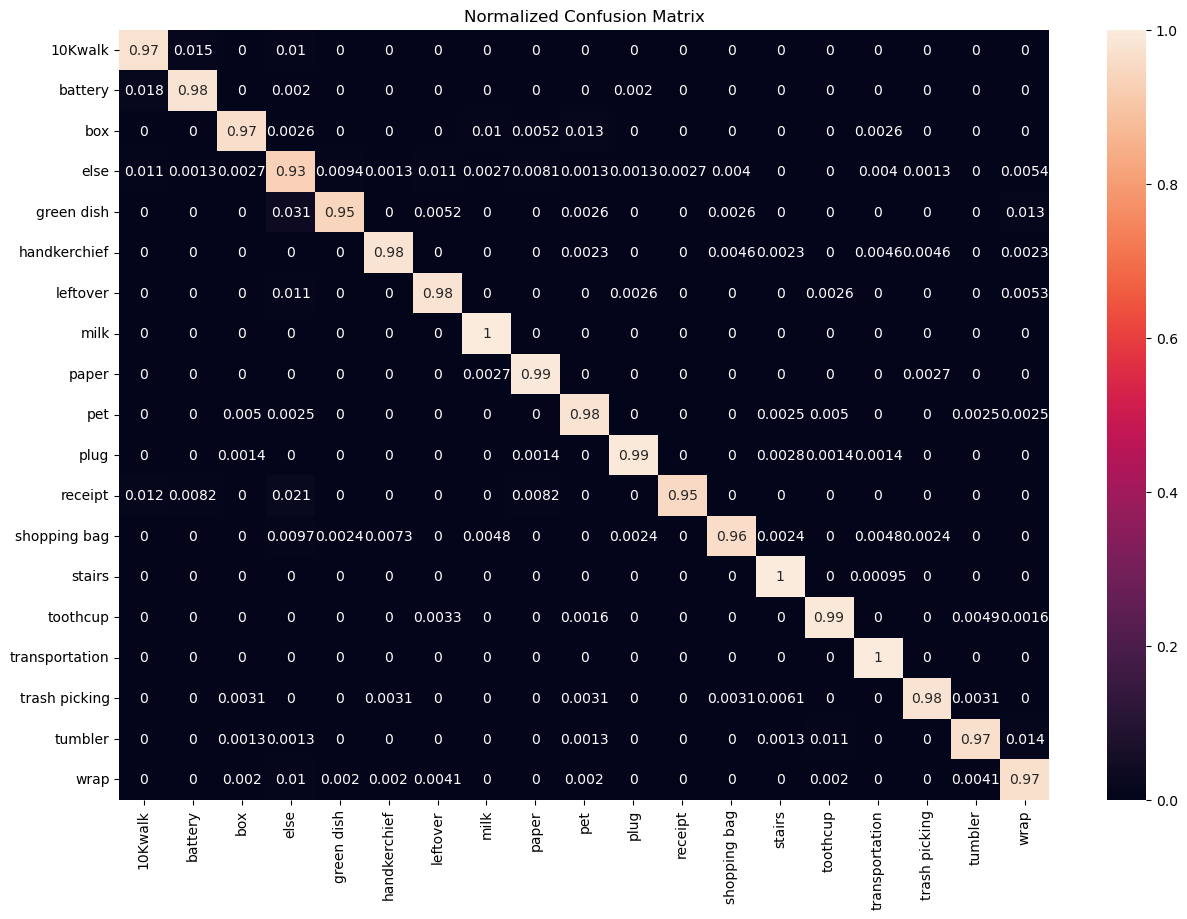

In [27]:
import seaborn as sns

test_acc = np.sum(test.label == test.pred) / len(test)
test_matrix = confusion_matrix(test['label'], test['pred'])
epoch_f1 = f1_score(test['label'], test['pred'], average='macro')
print(f'accuracy: {test_acc:.4f}')
print(f'f1_score: {epoch_f1:.4f}')

test_matrix = confusion_matrix(test['label'], test['pred'], normalize='true')
#test_matrix = confusion_matrix(test['label'], test['pred'])

plt.figure(figsize = (15,10))
sns.heatmap(test_matrix, 
            annot=True, 
            xticklabels = sorted(set(test['label'])), 
            yticklabels = sorted(set(test['label'])),
            )
plt.title('Normalized Confusion Matrix')
plt.show()

#print(f'confusion_matrix \n-------------------------\n {test_matrix}')

In [23]:
test.to_csv('test_result/incep_res_0403.csv', index=False)